# The Timeseries Stacked Quantum Autoencoder 
*TS QAE in PennyLane with angle encoding of TS sliding windows*

**By:** Jacob Cybulski, Arturk Strąg and Jakub Zwoniarski<br>
**Date:** August 2023 - November 2025<br>
**Aims:**
- The goal of this notebook is to build a TS QAE by training Stacked QAE.
- The models are to be build and tested in PennyLane.
- In this notebook data is generated and parameters are not saved.
- The notebook has lots of additional tests and serves training objectives.
- All such tests can be disabled by setting option debug=False.

**Sources:**
1. Phillip Lippe, Tutorial 9: Deep Autoencoders, UvA Deep Learning Tutorials, Fall 2022.
2. Ali Shannon, "techshot25/Autoencoders", accessed March 12, 2024, https://github.com/techshot25/Autoencoders.
3. Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium), Jun 28, 2021.
4. Eugenia Anello, <a href="https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb">GitHub</a>, Jun 28, 2021.

**Notes:**
- Refer to a separate "versions" notebook for the log of changes
- In the Stacked QAE we measure the outcome of the half-QAE and QAE rather than using SWAP test. It means that during the half-QAE measurement we lose the phase information that normally flows through the latent phase. When using SWAP test, phase is used during the comparison of qubit states and accumulated in the ancilla qubit. Such an approach should (in theory) lead to better training (even though it may be slower). However, the cost function based on SWAP test never refers to the values of qubits themselves. This means that in the process of their linear transformation, the range of values may actually change!
- As the Stacked model is difficult, and we need to carefully consider its structure and training
  - Data has been prepared in the range [0, 1]
  - Stacked model consists of data encoding, the QAE encoder, latent / trash space, and QAE decoder
  - Data is angle encoded in the range [-pi, 0], one window value per qubit
  - QAE decoder is a mirror image of the QAE encoder, but they use different parameters
  - Trash space qubits are reset to zero, so the latent space compressed input
  - The stacked-QAE uses expval measurements on all qubits, resulting in values in the range [-1, 1]
- The training regime is in three stages.
  - Stage 1: We train an adjoint of the decoder, which takes clean data, and I am using SWAP test to minimise trash space. In this way, the adjoint of the QAE decoder will learn how to recognise clean data. The common sense dictates that the better training is achieved in Stage 1, the better outcomes of Stages 2.
  - Stage 2: In stage 2, we will train the encoder to compress noisy input to match the expected compressed representation of the clean data.
    We train the QAE encoder linked via the latent space with the previously trained inverted QAE decoder, checking measuremets against expected values. 
  - Stage 3: The final model is ready for application.

In [1]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/envs/pl-42/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-42/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-42/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-42/lib/python3.11/site-packages',
 '.',
 '..']

*For some inexplicable reason, "import __<font color="red">torch</font>__" made "lightning-qubit" very fast,*<br>
*even though torch functions were not used (directly).*

In [2]:
### Imports
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import time
import pennylane as qml
import torch
from pennylane import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from qae_utils.Tools import draw_circuit
from qae_utils.Charts import plot_hist, meas_plot, multi_plot_flat_ts
from qae_utils.Files import create_folder_if_needed, write_json_file, write_ts_file
from qae_utils.Window import ts_add_noise, ts_wind_make, ts_wind_split, ts_wind_flatten_avg

# <font color="blue">Settings</font>

In [3]:
### Debug control
#   Switch to false to remove testing
debug = False

In [4]:
### Data settings

# Window settings
# - Intentionally selected as difficult
# - it means with step > 1
wind_size = 6
wind_step = 2
horizon = 1
noise = 0.2
split = 0.75

# Mackey-Glass data 
beta=0.17    # Larger beta = stronger oscillations
gamma=0.1    # Keeps damping moderate
n=10         # Standard nonlinearity
tau=30       # Introduces chaos (try 17–30 for interesting behavior)
x0=1.2       # Initial condition
length=1200  # Length of the generated series (to be shrunk to 200)

### Random seed(s)
seed = 2025

In [5]:
### Model and training setting
np.random.seed(seed)

# Simulator settings
#   On JC machine default is 10 times faster
sim = 'lightning.qubit' # 'default.qubit' # 
shots = None

# QAE settings
# - Intentionally selected as difficult
# - it means larger latent than trash space for 
#   synchronisation of sidekick encoder and decoder
n_wires = wind_size
n_latent = 4
n_trash  = n_wires - n_latent
n_layers = 4

n_inv_decoder_epochs = 500
n_stacked_epochs = 200

lr_inv_decoder_initial = 0.02
lr_stacked_initial = 0.05
lr_stacked_decay_rate = 0.7
lr_stacked_decay_steps = 20

rot = 'Rxyz'
inv_decoder_weight_scaler = 0.05
stacked_weight_scaler = 0.5
interface = 'autograd' # 'torch' # 
diff_method = 'adjoint' # 'parameter-shift' # 
batch_size = 10

# Data encoding setting
# - X is relevant to plotting only
# - Only y are used in windows
X_from = 0
X_to =   2*np.pi

# We need range 0..pi for sidekick encoding
# - Noise will be clipped to this range
#   which will falsify the value distribution
#   and lower the recovered values
y_margin = 0.0
y_low =  -np.pi+y_margin
y_high = 0-y_margin

## Utilities

In [6]:
##### Random seed generator
def rand_seed():
    t=time.time(); t = int((t-int(t))*10000)
    return t

In [7]:
##### Data scaler
def scale_values(x, new_min=0, new_max=1):
    scaler = MinMaxScaler(feature_range=(new_min, new_max))
    return scaler.fit_transform(x.reshape(-1, 1)).flatten()

# <font color="blue">Data preparation</font>

## <font color="red">Mackie-Glass dataset</font>

In [8]:
### Simulates the Mackey-Glass time series
def mackey_glass(length=1300, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2):
    x = np.zeros(length + tau + 1, dtype=float)
    x[:tau+1] = x0
    for t in range(tau, length + tau):
        xt = x[t]
        xt_tau = x[t - tau]
        dx = beta * xt_tau / (1.0 + xt_tau**n) - gamma * xt
        x[t+1] = xt + dx
    return x[tau+1:]

# Generate the Mackey-Glass time series
y_raw = mackey_glass(length=length, beta=beta, gamma=gamma, n=n, tau=tau, x0=x0)
y_raw = scale_values(y_raw, new_min=y_low, new_max=y_high)
y = y_raw[3::6] # reduce the number of points but keep the shape
X_raw = np.array([i for i in range(len(y))]) # Number points
X = scale_values(X_raw, new_min=X_from, new_max=X_to) # Keep the original coords

n_samples = len(y)

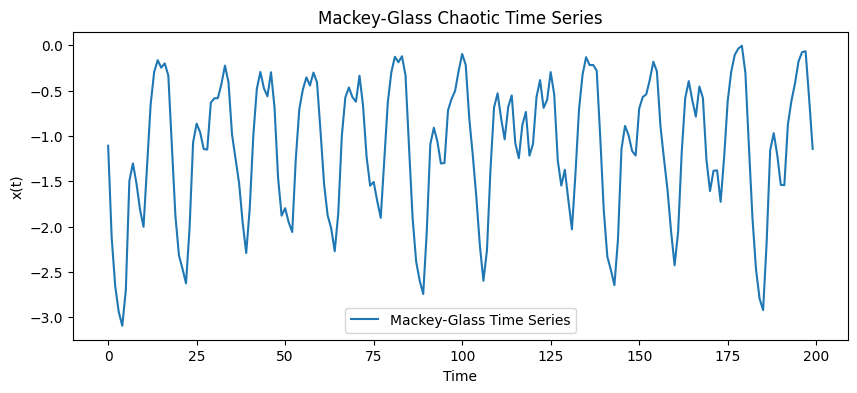

In [9]:
### Plot the Mackey-Glass time series
plt.figure(figsize=(10, 4))
plt.plot(y, label='Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

### Prepare data for training

In [10]:
### Makes mini-batches of time series windows
#   Yields: a mini-batch.
def get_mini_batches(W_noisy, W_clean, batch_size=10, shuffle=True, seed=0):
    if seed == 0: seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    num_samples = W_clean.shape[0]
    indices = np.arange(num_samples)
    if shuffle: np.random.shuffle(indices)

    for i in range(0, num_samples, batch_size):
        batch_indices = indices[i:i + batch_size]
        yield W_noisy[batch_indices], W_clean[batch_indices]

In [11]:
### Create time series tensor data with optional noise (note that windows overlap by wind_step)
def create_sw_tens(X, y, noise=0.0, wind_size=5, wind_step=2, range_low=0.2, range_high=0.8, seed=0):
    y_noisy = ts_add_noise(y, noise=noise, noise_type='normal', clip=True,
        range_low=range_low, range_high=range_high, seed=seed)
    y_ts = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = ts_wind_make(X, wind_size, wind_step)
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ts_wind_split(X_ts, y_ts, split)

    X_train_tens = np.tensor(X_train_ts, requires_grad=False)
    y_train_tens = np.tensor(y_train_ts, requires_grad=False)
    X_test_tens = np.tensor(X_test_ts, requires_grad=False)
    y_test_tens = np.tensor(y_test_ts, requires_grad=False)
    return X_train_tens, y_train_tens, X_test_tens, y_test_tens

In [12]:
from pprint import pprint

### Create windows and split into training and test partitions
X_train_coords, y_train_coords, X_test_coords, y_test_coords = \
        create_sw_tens(X, X, noise=0.0, wind_size=wind_size, wind_step=wind_step, range_low=y_low, range_high=y_high, seed=seed)
X_train_tens, y_train_tens, X_test_tens, y_test_tens = \
    create_sw_tens(y, y, noise=0.0, wind_size=wind_size, wind_step=wind_step, range_low=y_low, range_high=y_high, seed=seed)
_, X_train_noisy_tens, _, X_test_noisy_tens = \
    create_sw_tens(y, y, noise=noise, wind_size=wind_size, wind_step=wind_step, range_low=y_low, range_high=y_high, seed=seed)

### Find partition sizes
n_train = len(X_train_tens)
n_test = len(X_test_tens)

### Print a sample of data
print('\nSample of training partition:\n\nWindow coordinates:')
pprint(X_train_coords[0:3])
print('\nWindow values:')
pprint(X_train_tens[0:3]); 
print('\nSample of test partition:\n\nWindow coordinates:')
pprint(X_test_coords[0:3])
print('\nWindow values:')
pprint(X_test_tens[0:3]); print()


Sample of training partition:

Window coordinates:
tensor([[0.        , 0.0315738 , 0.06314759, 0.09472139, 0.12629518,
         0.15786898],
        [0.06314759, 0.09472139, 0.12629518, 0.15786898, 0.18944277,
         0.22101657],
        [0.12629518, 0.15786898, 0.18944277, 0.22101657, 0.25259036,
         0.28416416]], requires_grad=False)

Window values:
tensor([[-1.10897901, -2.12017946, -2.65757285, -2.94316572, -3.09494149,
         -2.70053654],
        [-2.65757285, -2.94316572, -3.09494149, -2.70053654, -1.49533306,
         -1.30424016],
        [-3.09494149, -2.70053654, -1.49533306, -1.30424016, -1.52307046,
         -1.81121119]], requires_grad=False)

Sample of test partition:

Window coordinates:
tensor([[4.67292174, 4.70449553, 4.73606933, 4.76764312, 4.79921692,
         4.83079071],
        [4.73606933, 4.76764312, 4.79921692, 4.83079071, 4.86236451,
         4.8939383 ],
        [4.79921692, 4.83079071, 4.86236451, 4.8939383 , 4.9255121 ,
         4.9570859 ]], re

### Plot flattened windows with sample noise
- Noise was clipped not to exceed the range [0..pi]

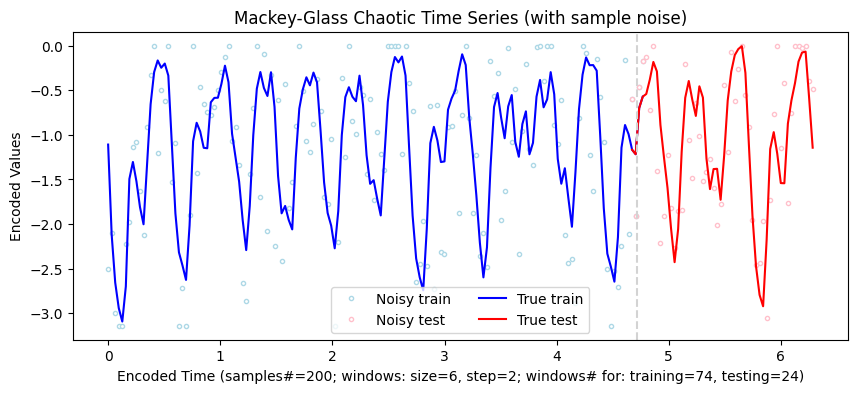

In [13]:
### Flatten windows by averaging overlapping data
X_train_flat_ts = ts_wind_flatten_avg(X_train_tens, wind_step)
X_test_flat_ts = ts_wind_flatten_avg(X_test_tens, wind_step)
X_train_noisy_flat_ts = ts_wind_flatten_avg(X_train_noisy_tens, wind_step)
X_test_noisy_flat_ts = ts_wind_flatten_avg(X_test_noisy_tens, wind_step)
X_train_flat_coords = ts_wind_flatten_avg(X_train_coords, wind_step)
X_test_flat_coords = ts_wind_flatten_avg(X_test_coords, wind_step)

# Plot partitions
plt.figure(figsize=(10, 4))
plt.plot(X_train_flat_coords, X_train_noisy_flat_ts, label="Noisy train", color="lightblue", linestyle='', mfc='white', marker='.')
plt.plot(X_test_flat_coords, X_test_noisy_flat_ts, label="Noisy test", color="pink", linestyle='', mfc='white', marker='.')
plt.plot(X_train_flat_coords, X_train_flat_ts, label="True train", color="blue")
plt.plot(X_test_flat_coords, X_test_flat_ts, label="True test", color="red")
plt.axvline(x=(X_train_flat_coords[-1]+X_test_flat_coords[0])/2, color="lightgray", linestyle='--')
plt.xlabel(f'Encoded Time (samples#={n_samples}; windows: size={wind_size}, step={wind_step}; windows# for: training={n_train}, testing={n_test})')
plt.ylabel('Encoded Values')
plt.title('Mackey-Glass Chaotic Time Series (with sample noise)')
plt.legend(loc='best', ncol=2)
plt.show()

# <font color="blue">Models building</font>

## <font color="red">Model utilities and tools</font>

In [14]:
### Encodes a sequence on in put (similar to AngleEncoding)
def sequence_encoder(wires, inputs):
    n_inputs = len(inputs)
    n_wires = len(wires)

    for i in range(len(wires)):
        if i > n_inputs-1:
            qml.RY(0, wires=wires[i])
        else:
            qml.RY(inputs[i], wires=wires[i])

### Entangler shape
def entangler_shape(n_layers, n_wires, rot='Ry'):
    if rot == 'Ry':
        return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    elif rot == 'Rxyz':
        return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    else:
        return ()

### Entangler
def entangler(weights, wires, rot='Ry'):
    if rot == 'Ry':
        qml.BasicEntanglerLayers(weights, wires=wires, rotation=qml.RY)
    elif rot == 'Rxyz':
        qml.StronglyEntanglingLayers(weights, wires=wires)

def swap(from_wires, to_wires):
    for i in range(len(from_wires)):
        qml.SWAP(wires=[from_wires[i], to_wires[i]])

def swap_test(from_wires, to_wires, ancila_wire):
    qml.Hadamard(wires=ancila_wire)
    for i in range(len(from_wires)):
        qml.CSWAP(wires=[ancila_wire, from_wires[i], to_wires[i]])
    qml.Hadamard(wires=ancila_wire)

def qae_encoder(weights, inputs, wires, n_latent=4, n_trash=0, n_layers=1, rot='Ry', invert=False):
    n_zero = n_trash
    latent_wires = wires[0:n_latent]
    trash_wires = wires[n_latent:n_latent+n_trash]
    data_wires = latent_wires + trash_wires
    anz_wires = latent_wires + trash_wires
    
    if invert:
        # Add inverted input encoder
        sequence_encoder(data_wires, -1*inputs)
        qml.Barrier(wires)

        # Add entangling block
        qml.adjoint(entangler)(weights, anz_wires, rot=rot)
    else:
        # Add input encoder
        sequence_encoder(data_wires, inputs)
        qml.Barrier(wires)

        # Add entangling block
        entangler(weights, anz_wires, rot=rot)

### <font color="red">Cost function on SWAP test results</font>
- SWAP test is utilised
- Interporetayion $P(\vert 1 \rangle) = 1$ areas are the same, $P(\vert 1 \rangle) = 0.5$ maximally different
- Only ancila qubit is measured (probability of $P(\vert 1 \rangle) = 1$)
- Cost function is $cost = 1-P(\vert 1 \rangle)$

In [15]:
### Our own SWAP test ancila 1-P(1) cost
#   Beware in PennyLane these MUST be very pure
#   to be differentiable (so not external / fancy functions)
def cost_probs_on_ancila(expvals):
    cost = 0
    vals = len(expvals)
    for i in range(vals):
        p1 = (1 - expvals[i]) / 2
        cost = cost + p1
    return cost / vals

### The cost function generator
def cost_fun_gen_on_probs(model, cost_fun):
    def _cost_fun(params, inputs):
        nonlocal model, cost_fun
        expvals = np.stack([model(params, x) for x in inputs])
        return cost_fun(expvals)
    return _cost_fun

### Our own gradient-friendly loss/cost function
#   Beware in PennyLane these MUST be very pure
#   to be differentiable (so not external / fancy functions)
def mse_cost_on_tensors(targets, predictions):
    cost = 0
    vals = 0
    for i in range(len(targets)):
        for w in range(len(targets[i])):
            cost = cost + (targets[i][w] - predictions[i][w]) ** 2
            vals += 1
    cost = cost / vals
    return cost

### The cost function generator
def cost_fun_gen_on_tensors(model, cost_fun):
    def _cost_fun(params, inputs, targets):
        nonlocal model, cost_fun
        preds = [model(params, x) for x in inputs]
        return cost_fun(targets, preds)
    return _cost_fun

In [16]:
### Testing cost function
if debug:
    test_dev = qml.device(sim, wires=3, seed=seed, shots=shots)
    @qml.qnode(test_dev, interface=interface, diff_method=diff_method)
    def swap_test_circuit(weights, inputs):
        ancilla_wire = 2; target_wire = 0; variational_wire = 1
        qml.RY(inputs[0], wires=target_wire)
        qml.RY(weights[0], wires=variational_wire)
        qml.Hadamard(wires=ancilla_wire)
        qml.CSWAP(wires=[ancilla_wire, target_wire, variational_wire])
        qml.Hadamard(wires=ancilla_wire)
        return qml.expval(qml.PauliZ(ancilla_wire))

    test_weights = [3.14]
    test_single = [3]
    test_input1 = [[3], [3.1], [3.14]]
    test_input2 = [[-1.2], [2.1], [0.14]]
    draw_circuit(swap_test_circuit, scale=0.7, fontsize=14, decimals=3, 
        title=f'Example SWAP test\nWeights={test_weights}, Input={test_single}', 
        level='device')(test_weights, test_single)
    test_cost = cost_fun_gen_on_probs(swap_test_circuit, cost_probs_on_ancila)
    print(f'Single model result: {float(np.round(swap_test_circuit(test_weights, [3]), 3))} '+\
          f'for ({[float(np.round(num, 3)) for num in test_weights]} vs {test_single})')
    print(f'High similarity cost (~0.0): {test_cost(test_weights, test_input1):0.3f}  '+\
          f'for ({[float(np.round(num, 3)) for num in test_weights]} vs {test_input1})')
    print(f'Low  similarity cost (~0.5): {test_cost(test_weights, test_input2):0.3f}  '+\
          f'for ({[float(np.round(num, 3)) for num in test_weights]} vs {test_input2})');

### <font color="red">Sequential block of angle encoding</font>
- Use only to test sequence_encoder

In [17]:
def qae_seq_model(wires, n_data_wires, n_inputs):
    n_wires = len(wires)

    def _qae_seq_model(inputs):
        nonlocal n_wires, n_data_wires, n_inputs
        data_wires = wires[:n_data_wires]
        sequence_encoder(data_wires, inputs)
        return [qml.expval(qml.PauliZ(m)) for m in data_wires]
    return _qae_seq_model

In [18]:
if debug:
    test_n_latent = 2; test_n_trash = 2
    test_n_inputs = test_n_latent + test_n_trash
    test_n_wires = test_n_latent + test_n_trash
    test_wires = list(range(test_n_wires))
    
    raw_data = [0.5, 0.75, -0.25, -0.1]
    test_data = np.array([np.arccos(x) for x in raw_data], requires_grad=False)
    print(f'\nAmplitude input data {test_data.shape}: \n{raw_data}\n')
    print(f'Angular input data {test_data.shape}: \n{test_data}\n')
    
    ### Testing QAE encoder
    
    # Define a static QAE encoder
    test_qae_seq = qae_seq_model(test_wires, test_n_wires, test_n_wires)
    
    # Create and draw a QAE encoder
    test_dev = qml.device(sim, wires=range(test_n_wires), seed=seed, shots=shots)
    test_qae_seq_qc = qml.QNode(test_qae_seq, test_dev, interface=interface, diff_method=diff_method)
    draw_circuit(test_qae_seq_qc, scale=0.5, title='QAE Encoder+Output', level='device')(test_data)

    # Plot the results
    expvals = test_qae_seq_qc(test_data)
    plot_hist(expvals, figsize=(8, 4), ylabel='ExpVal', xlabel='Qubit',
              title='Output: Measuring expectation values of each qubit',
              labels=[str(i) for i in range(len(test_data))])

## <font color="red">Inverted half-QAE decoder</font>
- As decoder is an inverted encoder, it is inverted(inverted(entangler)) = entangler
- Training is on SWAP test of trash (with measurement)

### Model definition

In [19]:
def qae_inv_decoder_model_shape(n_latent, n_trash, n_layers=1, rot='Ry'):
    return entangler_shape(n_layers, n_latent+n_trash, rot=rot)

def qae_inv_dencoder_model(wires, n_latent, n_trash, n_layers=1, rot='Ry', invert=False):

    n_zero = n_trash
    latent_wires = wires[0:n_latent]
    trash_wires = wires[n_latent:n_latent+n_trash]
    zero_wires = wires[n_latent+n_trash:n_latent+n_trash+n_zero]
    data_wires = latent_wires + trash_wires
    anz_wires = latent_wires + trash_wires
    ancila_wire = wires[-1]

    ### Full QAE encoder
    def _qae_inv_decoder(weights, inputs):
        
        nonlocal wires, n_latent, n_trash, n_zero, n_layers, rot
        nonlocal latent_wires, trash_wires, zero_wires, data_wires, anz_wires, ancila_wire
        nonlocal invert

        # Add inverted input encoder (pure data)
        sequence_encoder(data_wires, inputs)
        qml.Barrier(wires)

        # Add entangling block
        entangler(weights, anz_wires, rot=rot)
  
        # Add swap space
        qml.Barrier(wires)
        swap_test(trash_wires, zero_wires, ancila_wire)
        qml.Barrier(wires)

        return qml.expval(qml.PauliZ(ancila_wire))

    return _qae_inv_decoder

### Model testing

In [20]:
### Testing inverted decoder structure with SWAP test
if debug:
    test_n_latent = 2; test_n_trash = 2; test_n_layers=2
    test_n_inputs = test_n_latent + test_n_trash
    test_n_wires = test_n_latent + 2*test_n_trash + 1
    test_wires = list(range(test_n_wires))
    test_rot = 'Rxyz'
    
    raw_data = [0.5, 0.75, -0.25, -0.1]
    test_data = np.array([np.arccos(x) for x in raw_data], requires_grad=False)
    print(f'\nAmplitude data {test_data.shape}: \n{raw_data}\n')
    print(f'Angular data {test_data.shape}: \n{test_data}\n')
    
    test_shape = qae_inv_decoder_model_shape(test_n_latent, test_n_trash, test_n_layers, test_rot)
    test_n_weights = np.prod(test_shape)
    print(f'QAE inv decoder shape: {test_shape}, weights: {int(test_n_weights)}\n')
    
    # test_data = np.linspace(100, 200, test_n_inputs, requires_grad=False)
    test_weights = np.random.rand(*test_shape, requires_grad=True)
    
    print(f'Data {test_data.shape}: \n{test_data}\n')
    print(f'Weights {test_weights.shape}: \n{test_weights}\n')
    
    ### Testing QAE encoder
    
    # Define a static QAE encoder
    test_qae_inv_decoder = qae_inv_dencoder_model(test_wires, test_n_latent, test_n_trash, 
        test_n_layers, test_rot, invert=True)
    
    # Create and draw a QAE encoder
    test_dev = qml.device(sim, wires=range(test_n_wires+2*test_n_trash+1), seed=seed, shots=shots)
    test_qae_inv_decoder_qc = qml.QNode(test_qae_inv_decoder, test_dev, interface=interface, diff_method=diff_method)
    draw_circuit(test_qae_inv_decoder_qc, scale=0.5, decimals=3, title='QAE Encoder+Output', level='device') \
        (test_weights, test_data) # expansion_strategy='device'/'gradient'

## <font color="red">Stacked model</font>
- Consists of sequence + encoder + (latent || trash + zero swap) + decoder
- As decoder has already been trained it weights are fixed and added to stacked QAE at creation
- Synchronisation is via latent space

### Model definition
- Stacked decoder weights are fixed, so only encoder weights are used

In [21]:
### Definition of shape and model
def qae_stacked_model_shape(n_latent, n_trash, n_layers=1, rot='Ry'):
    return entangler_shape(n_layers, n_latent+n_trash, rot=rot)

def qae_stacked_model(wires, dec_weights, n_latent, n_trash, n_layers=1, rot='Ry'):

    n_zero = n_trash
    latent_wires = wires[0:n_latent]
    trash_wires = wires[n_latent:n_latent+n_trash]
    zero_wires = wires[n_latent+n_trash:n_latent+n_trash+n_zero]
    data_wires = latent_wires + trash_wires
    anz_wires = latent_wires + trash_wires

    ### Full QAE encoder
    def _qae_stacked_model(enc_weights, inputs):
        
        nonlocal wires, n_latent, n_trash, n_zero, n_layers, rot
        nonlocal latent_wires, trash_wires, zero_wires, data_wires, anz_wires
        nonlocal dec_weights

        # Add encoder
        sequence_encoder(data_wires, inputs)
        entangler(enc_weights, data_wires, rot=rot)
  
        # Add swap space
        qml.Barrier(wires)
        swap(trash_wires, zero_wires)
        qml.Barrier(wires)
  
        # Add decoder
        # However, decoder is an inverted entangler
        qml.adjoint(entangler)(dec_weights, data_wires, rot=rot)

        # Convert the final values to their adjoint
        # for q in data_wires:
        #     qml.PauliX(wires=q)

        return [qml.expval(qml.PauliZ(m)) for m in data_wires]

    return _qae_stacked_model

### Model testing

In [22]:
### Testing Sidekick structure with SWAP test
if debug:
    test_n_latent = 2; test_n_trash = 2; test_n_layers=2
    test_n_inputs = test_n_latent + test_n_trash
    test_n_wires = test_n_latent + 2*test_n_trash
    test_wires = list(range(test_n_wires))
    test_rot = 'Rxyz'
    
    raw_data = [0.5, 0.75, -0.25, -0.1]
    test_data = np.array([np.arccos(x) for x in raw_data], requires_grad=False)
    print(f'\nAmplitude data {test_data.shape}: \n{raw_data}\n')
    print(f'Angular data {test_data.shape}: \n{test_data}\n')
    
    test_dec_shape = entangler_shape(test_n_layers, test_n_latent+test_n_trash, test_rot) # Fixed weights
    test_enc_shape = entangler_shape(test_n_layers, test_n_latent+test_n_trash, test_rot)
    test_n_weights = np.prod(test_enc_shape)
    print(f'Stacked QAE shape: {test_enc_shape}, weights: {int(test_n_weights)}\n')
    
    # Create 1 data point
    test_enc_data = test_data # np.linspace(i*np.pi/10, (i+1)*np.pi/10, test_n_inputs, requires_grad=False)
    test_stacked_data = np.array(test_enc_data)
    
    test_dec_init_weights = np.array([100+i for i in range(test_n_weights)]).reshape(*test_dec_shape) # Fixed weights
    test_enc_init_weights = np.random.rand(*test_enc_shape, requires_grad=True)
    
    print(f'Data {test_stacked_data.shape}: \n{test_stacked_data}\n')
    print(f'Decoder Fixed Weights {test_dec_init_weights.shape}: \n{test_dec_init_weights}\n')
    print(f'Encoder Init  Weights {test_enc_init_weights.shape}: \n{test_enc_init_weights}\n')
    
    ### Testing sidekick QAE
    
    # Define a static sidekick QAE encoder
    test_qae_stacked = qae_stacked_model(test_wires, test_dec_init_weights,
        test_n_latent, test_n_trash, test_n_layers, test_rot)
    
    # Create and draw a sidekick-QAE
    test_dev = qml.device(sim, wires=range(test_n_wires), seed=seed, shots=shots)
    test_qae_stacked_qc = qml.QNode(test_qae_stacked, test_dev, interface=interface, diff_method=diff_method)
    draw_circuit(test_qae_stacked_qc, scale=0.5, decimals=3, title='QAE Stacked+Output', level='device') \
        (test_weights, test_stacked_data) # expansion_strategy='device'/'gradient'

## <font color="red">Full QAE reintegrated model</font>
- Consists of sequence + decoder + encoder
- Encoder is an entangler
- Decoder is a mirror image of encoder, so it is inverted(entangler)
- As encoder and decoder have already been trained, there are no trainable weights
- Trash is SWAP with zeroe qubits (no measurement)

_Add sidekick fixed weights to encoder and decoder at creation_

### Model definition

In [23]:
def qae_full_model(wires, enc_weights, dec_weights, n_latent, n_trash, n_layers, rot):

    n_zero = n_trash
    latent_wires = wires[0:n_latent]
    trash_wires = wires[n_latent:n_latent+n_trash]
    zero_wires = wires[n_latent+n_trash:n_latent+n_trash+n_zero]
    data_wires = latent_wires + trash_wires
    anz_wires = latent_wires + trash_wires

    ### Full QAE encoder
    def _qae_full(inputs):
        
        nonlocal wires, n_latent, n_trash, n_zero, n_layers, rot
        nonlocal latent_wires, trash_wires, zero_wires, data_wires, anz_wires
        nonlocal enc_weights, dec_weights

        # Add encoder
        sequence_encoder(data_wires, inputs)
        entangler(enc_weights, data_wires, rot=rot)
  
        # Add swap space
        qml.Barrier(wires)
        swap(trash_wires, zero_wires)
        qml.Barrier(wires)
  
        # Add decoder
        # However, decoder is an inverted entangler
        qml.adjoint(entangler)(dec_weights, data_wires, rot=rot)

        # Convert the final values to their adjoint
        # for q in data_wires:
        #     qml.PauliX(wires=q)

        return [qml.expval(qml.PauliZ(m)) for m in data_wires]

    return _qae_full

### Testing full-QAE structure

In [24]:
### Testing full-QAE structure
if debug:
    
    ### Test full-QAE structure
    test_n_latent = 2; test_n_trash = 2; test_n_layers=2
    test_n_inputs = test_n_latent + test_n_trash # but need twice as much
    test_n_wires = test_n_latent + 2*test_n_trash
    test_wires = list(range(test_n_wires))
    test_rot = 'Rxyz'
    
    raw_data = [0.5, 0.75, -0.25, -0.1]
    test_data = np.array([np.arccos(x) for x in raw_data], requires_grad=False)
    print(f'\nAmplitude data {test_data.shape}: \n{raw_data}\n')
    print(f'Angular data {test_data.shape}: \n{test_data}\n')
    
    test_dec_shape = entangler_shape(test_n_layers, test_n_latent+test_n_trash, test_rot) # Fixed weights
    test_enc_shape = entangler_shape(test_n_layers, test_n_latent+test_n_trash, test_rot) # Fixed weights
    test_n_weights = np.prod(test_enc_shape)
    print(f'Full QAE fixed shape: {test_enc_shape}+{test_dec_shape}, weights: {int(2*test_n_weights)}\n')
    
    test_dec_init_weights = np.array([100+i for i in range(test_n_weights)]).reshape(*test_dec_shape) # Fixed weights
    test_enc_init_weights = np.random.rand(*test_enc_shape, requires_grad=True)
    
    print(f'Data {test_data.shape}: \n{test_data}\n')
    print(f'Encoder Init  Weights {test_enc_init_weights.shape}: \n{test_enc_init_weights}\n')
    print(f'Decoder Fixed Weights {test_dec_init_weights.shape}: \n{test_dec_init_weights}\n')
    
    ### Testing full QAE
    
    # Define a static QAE encoder
    test_qae_full = qae_full_model(test_wires, test_enc_init_weights, test_dec_init_weights,
        test_n_latent, test_n_trash, test_n_layers, test_rot)
    
    # Create and draw a full-QAE, add wires for SWAP space (only latent area goes through)
    test_dev = qml.device(sim, wires=range(2*(test_n_wires+test_n_trash)+1), seed=seed, shots=shots)
    test_qae_full_qc = qml.QNode(test_qae_full, test_dev)
    draw_circuit(test_qae_full_qc, scale=0.7, decimals=3, title='QAE Full+Input+Output', level='device') \
        (test_data) # expansion_strategy='device'/'gradient'

### Testing full-QAE function

In [25]:
### Testing full-QAE function
#   Without trash in QAE with mirrored weights, information can be fully recovered
if debug:
    
    test_n_latent = 4; test_n_trash = 0; test_n_layers=2
    test_n_inputs = test_n_latent + test_n_trash # but need twice as much
    test_n_wires = test_n_latent + 2*test_n_trash
    test_wires = list(range(test_n_wires))
    test_rot = 'Rxyz'
    
    raw_data = [0.5, 0.75, -0.25, -0.1]
    test_data = np.array([np.arccos(x) for x in raw_data], requires_grad=False)
    print(f'\nAmplitude data {test_data.shape}: \n{raw_data}\n')
    print(f'Angular data {test_data.shape}: \n{test_data}\n')
    
    test_enc_shape = entangler_shape(test_n_layers, test_n_latent+test_n_trash, test_rot)
    test_dec_shape = entangler_shape(test_n_layers, test_n_latent+test_n_trash, test_rot) # Mirror structure
    test_n_weights = np.prod(test_enc_shape)
    print(f'Full QAE fixed shape: {test_enc_shape}+{test_dec_shape}, weights: {int(2*test_n_weights)}\n')
    
    test_dec_init_weights = \
        np.array([2*np.pi/test_n_weights*i for i in range(test_n_weights)], requires_grad=True).reshape(*test_dec_shape) # Fixed weights
    test_enc_init_weights = test_dec_init_weights # Mirror weights
    
    print(f'Data {test_data.shape}: \n{test_data}\n')
    print(f'Encoder Fixed Weights {test_enc_init_weights.shape}: \n{test_enc_init_weights}\n')
    print(f'Decoder Fixed Weights {test_dec_init_weights.shape}: \n{test_dec_init_weights}\n')
    
    ### Testing full QAE
    
    # Define a static QAE encoder
    test_qae_full = qae_full_model(test_wires, test_enc_init_weights, test_dec_init_weights,
        test_n_latent, test_n_trash, test_n_layers, test_rot)
    
    # Create and draw a full-QAE, add wires for SWAP space (only latent area goes through)
    test_dev = qml.device(sim, wires=range(2*(test_n_wires+test_n_trash)+1), seed=seed, shots=shots)
    test_qae_full_qc = qml.QNode(test_qae_full, test_dev, interface=interface, diff_method=diff_method)
    result = np.stack(test_qae_full_qc(test_data))
    print('Test result: ',[f'{val:.3f}' for val in result], '\n')
    
    plot_hist(result, figsize=(8, 4), ylabel='ExpVal', xlabel='Qubit',
              title='Orginal raw data',
              labels=[str(i) for i in range(len(raw_data))])
    plot_hist(result, figsize=(8, 4), ylabel='ExpVal', xlabel='Qubit',
              title='Measured expectation values',
              labels=[str(i) for i in range(len(test_data))])

# <font color="blue">Model training</font>

## <font color="red">Inverted decoder training</font>

### Training loop

In [26]:
##### Training loop

def train_dec_without_noise(model, X, cost_fun, optimizer, n_epochs, init_weights, 
    log_interv=1, prompt_fract=0.1, start_time=0, level=2, seed=0, scale_low=0.1, scale_high=0.9,
    wind_size=8, wind_step=4, noise=0, weight_scaler=0.1):

    ### For reproducibility
    #   Set a default random seed
    if seed == 0: seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    
    ### Prepare training
    hist_cost = []
    hist_params = []
    params = weight_scaler*init_weights.copy()
    
    ### Prepare tensors of pure training windows to be used as y output
    #   We ignore the test partition in training
    _, y_pure_tens, _, _ = create_sw_tens(X, X, noise=0, seed=seed,
        wind_size=wind_size, wind_step=wind_step, range_low=scale_low, range_high=scale_high)
    
    ### Set the clock
    if start_time == 0: start_time = time.time() 
        
    ### Training loop
    for iter in range(n_epochs):    
        params, cost = optimizer.step_and_cost(lambda p: cost_fun(p, y_pure_tens), params)
        elapsed_time = time.time()-start_time
        if iter % log_interv == 0:
            hist_cost.append(cost)
            hist_params.append(params)
        if (prompt_fract == 0) or (iter % int(prompt_fract*n_epochs) == 0):
            print(f'Iter: {iter:03d} ({int(elapsed_time):04d} sec) cost={np.round(cost, 6)}')
    
    ### Print the training summary
    min_cost = np.min(hist_cost)
    min_iter = np.argmin(hist_cost)
    opt_params = hist_params[min_iter]
    
    ### Print the training summary
    print(f'\nTraining completed: epochs={n_epochs}, min cost={np.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

    return hist_cost, hist_params, init_weights, (min_iter, min_cost, elapsed_time)

### Model preparation for training
- Here we have an invverted decoder (so it is an inverted(inverted(entangler)))
- Decoder is to be trained, so all its weights are trainable
- Decoder weights are created in range [-2*pi, 2*pi] but subject to weight_scaler multiplier (0.1)

QAE inv decoder shape: (4, 6, 3), weights: 72

Weights shape: (4, 6, 3)
Pure data y shape: (74, 6)
Wires (9): [0, 1, 2, 3, 4, 5, 6, 7, 8]



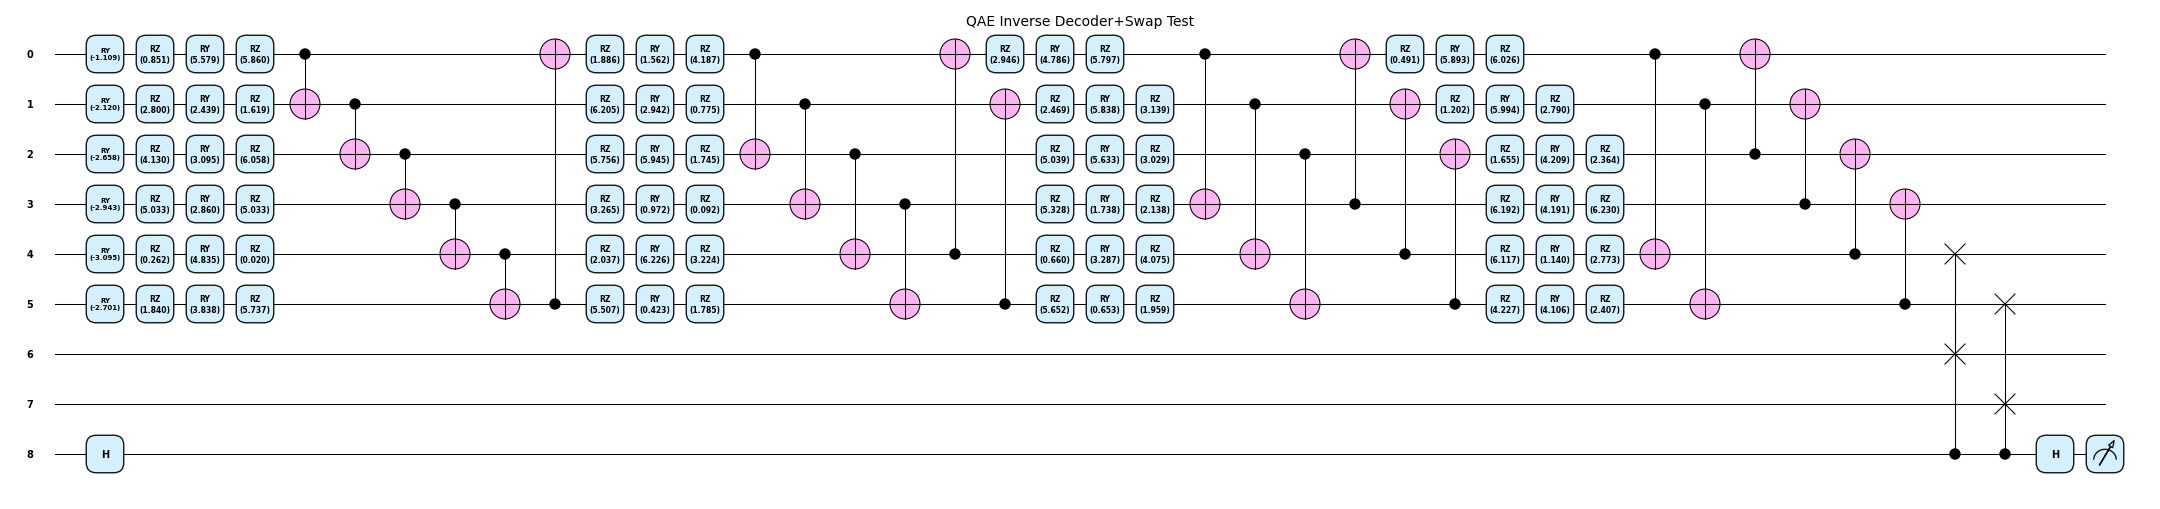

In [27]:
### For reproducibility
np.random.seed(seed)

### Traing the inverted decoder
inv_decoder_shape = qae_inv_decoder_model_shape(n_latent, n_trash, n_layers, rot)
inv_decoder_n_weights = np.prod(inv_decoder_shape)
print(f'QAE inv decoder shape: {inv_decoder_shape}, weights: {int(inv_decoder_n_weights)}\n')

inv_decoder_init_weights = np.random.rand(*inv_decoder_shape, requires_grad=True)*2*np.pi
print(f'Weights shape: {inv_decoder_init_weights.shape}')

### Pure data for training
print(f'Pure data y shape: {y_train_tens.shape}')

### Quantum simulator
inv_decoder_n_wires = n_latent+2*n_trash+1
inv_decoder_wires = list(range(inv_decoder_n_wires))
print(f'Wires ({inv_decoder_n_wires}): {inv_decoder_wires}\n')

# Define a static QAE encoder
qae_inv_decoder = qae_inv_dencoder_model(inv_decoder_wires, 
    n_latent, n_trash, n_layers, rot)

# Create and draw a QAE inverse decoder
inv_decoder_dev = qml.device(sim, wires=inv_decoder_wires, seed=seed, shots=shots)
qae_inv_decoder_qc = qml.QNode(qae_inv_decoder, inv_decoder_dev, interface=interface, diff_method=diff_method)
draw_circuit(qae_inv_decoder_qc, scale=0.5, decimals=3, title='QAE Inverse Decoder+Swap Test', level='device') \
    (inv_decoder_init_weights, y_train_tens[0])

### Training run

In [28]:
### For reproducibility
np.random.seed(seed)

### Preparation for training
opt = qml.AdamOptimizer(stepsize=lr_inv_decoder_initial)
cost_fun = cost_fun_gen_on_probs(qae_inv_decoder_qc, cost_probs_on_ancila)

### Training run
hist_cost, hist_params, init_weights, stats = train_dec_without_noise(
    qae_inv_decoder, y, cost_fun, opt, n_inv_decoder_epochs, inv_decoder_init_weights, 
    wind_size=wind_size, wind_step=wind_step, noise=0, weight_scaler=inv_decoder_weight_scaler,
    prompt_fract=0.1, seed=seed, scale_low=y_low, scale_high=y_high)

Iter: 000 (0000 sec) cost=0.306122
Iter: 050 (0030 sec) cost=0.182376
Iter: 100 (0058 sec) cost=0.154667
Iter: 150 (0088 sec) cost=0.146927
Iter: 200 (0117 sec) cost=0.117285
Iter: 250 (0147 sec) cost=0.113508
Iter: 300 (0176 sec) cost=0.108389
Iter: 350 (0204 sec) cost=0.105986
Iter: 400 (0233 sec) cost=0.10597
Iter: 450 (0262 sec) cost=0.105962

Training completed: epochs=500, min cost=0.105948 @ 499, time=290 secs



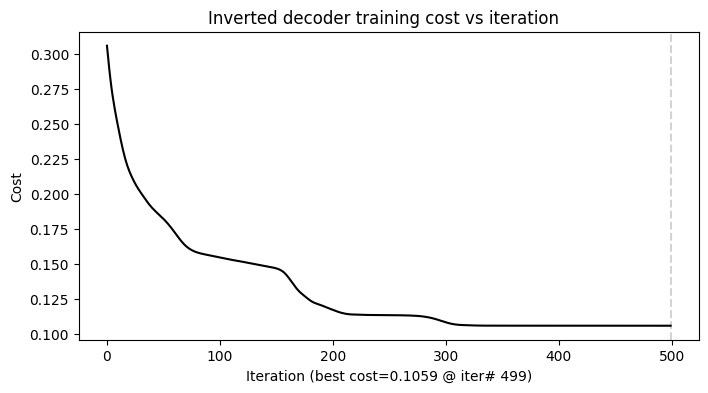

In [29]:
### Plot training cost
#   Note that best model may not have been saved
#   because models are being saved at predefined intervals (log_interv)
meas_plot(hist_cost, meas='cost', task='min', title_pref='Inverted decoder training',
    rcParams=(8, 4), log_interv=1,
    backplot=False, back_color='linen', smooth_weight=0.0)

In [30]:
inv_decoder_train_opt = int(stats[0])
inv_decoder_cost_opt = np.round(hist_cost[inv_decoder_train_opt], 5)
inv_decoder_costs = np.array(hist_cost)
inv_decoder_weights = np.array(hist_params, requires_grad=True)
inv_decoder_init_weights = np.array(init_weights, requires_grad=True)
inv_decoder_opt_weights = np.array(hist_params[inv_decoder_train_opt], requires_grad=True)
print(f'Finished training inverted decoder. Retained:\n')
print(f'Costs {inv_decoder_costs.shape}: {inv_decoder_cost_opt} @ {inv_decoder_train_opt}')
print(f'Weights {inv_decoder_weights.shape}')
print(f'Initial weights {inv_decoder_init_weights.shape}')
print(f'Optimum weights {inv_decoder_opt_weights.shape}')

Finished training inverted decoder. Retained:

Costs (500,): 0.10595 @ 499
Weights (500, 4, 6, 3)
Initial weights (4, 6, 3)
Optimum weights (4, 6, 3)


## <font color="red">Stacked training</font>
We will assume that data X and y are identical, scaled to the range [-pi, 0]

In [31]:
##### Training loop
def train_stacked_with_noise(model, W, cost_fun, optimizer, n_epochs, init_weights, 
    log_interv=1, prompt_fract=0.1, start_time=0, level=2, seed=0,
    wind_size=8, wind_step=4, noise=0, weight_scaler=0.1, scale_low=0.1, scale_high=0.9):

    ### For reproducibility
    #   Set a default random seed
    if seed == 0: seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    
    ### Prepare training
    hist_cost = []
    hist_params = []

    ### Initialise weights (note that model already knows of dec weights)
    params = weight_scaler*init_weights.copy()
    
    ### Prepare tensors of pure training windows to be used as y output
    #   We ignore the test partition in training
    _, y_pure, _, _ = create_sw_tens(W, W, noise=0, seed=seed,
        wind_size=wind_size, wind_step=wind_step, range_low=scale_low, range_high=scale_high)

    ### Rescale targets to expvals [1..-1]
    y_pure = y_pure / np.pi * 2 + 1
    
    ### Set the clock
    if start_time == 0: start_time = time.time() 
        
    ### Training loop
    for iter in range(n_epochs):
    
        # Add noise to pure windows to be used as X input
        #   We ignore the test partition in training
        _, X_noisy, _, _ = create_sw_tens(W, W, noise=noise, seed=seed+iter,
            wind_size=wind_size, wind_step=wind_step, range_low=scale_low, range_high=scale_high)

        # Decay learning rate
        if (iter+1) % lr_stacked_decay_steps == 0: 
            optimizer.stepsize *= lr_stacked_decay_rate

        # Train the model in mini-batches
        batches = get_mini_batches(X_noisy, y_pure, batch_size=batch_size, shuffle=True, seed=seed+iter)
        acc_batch_cost = 0
        for batch_no, (noisy_batch, pure_batch) in enumerate(batches):
            params, batch_cost = optimizer.step_and_cost(lambda p: cost_fun(p, noisy_batch, pure_batch), params)
            acc_batch_cost += batch_cost
        cost = acc_batch_cost / (batch_no+1)

        # End of epoch processing
        elapsed_time = time.time()-start_time
        if iter % log_interv == 0:
            hist_cost.append(cost)
            hist_params.append(params)
        if (prompt_fract == 0) or (iter % int(prompt_fract*n_epochs) == 0):
            print(f'Iter: {iter:03d} ({int(elapsed_time):04d} sec) cost={cost:0.6f} '+\
                  f'(opt LR={optimizer.stepsize:0.4f})')
    
    ### Print the training summary
    min_cost = np.min(hist_cost)
    min_iter = np.argmin(hist_cost)
    opt_params = hist_params[min_iter]
    
    ### Print the training summary
    print(f'\nTraining completed: epochs={n_epochs}, min cost={np.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

    return hist_cost, hist_params, init_weights, (min_iter, min_cost, elapsed_time)

### Model preparation for training
- Decoder has been previously trained, so its weights are fixed
- Encoder is to be trained, so its weights are sidekick trainable
- Encoder weights are created in range [-2*pi, 2*pi] but are subject to weight_scaler multiplier (0.1)

Stacked QAE shape: (4, 6, 3), weights: 72

Fixed inv decoder init weights shape: (4, 6, 3)
Trainable encoder init weights shape: (4, 6, 3)
Pure data y shape: (74, 6)

Wires (8): [0, 1, 2, 3, 4, 5, 6, 7]



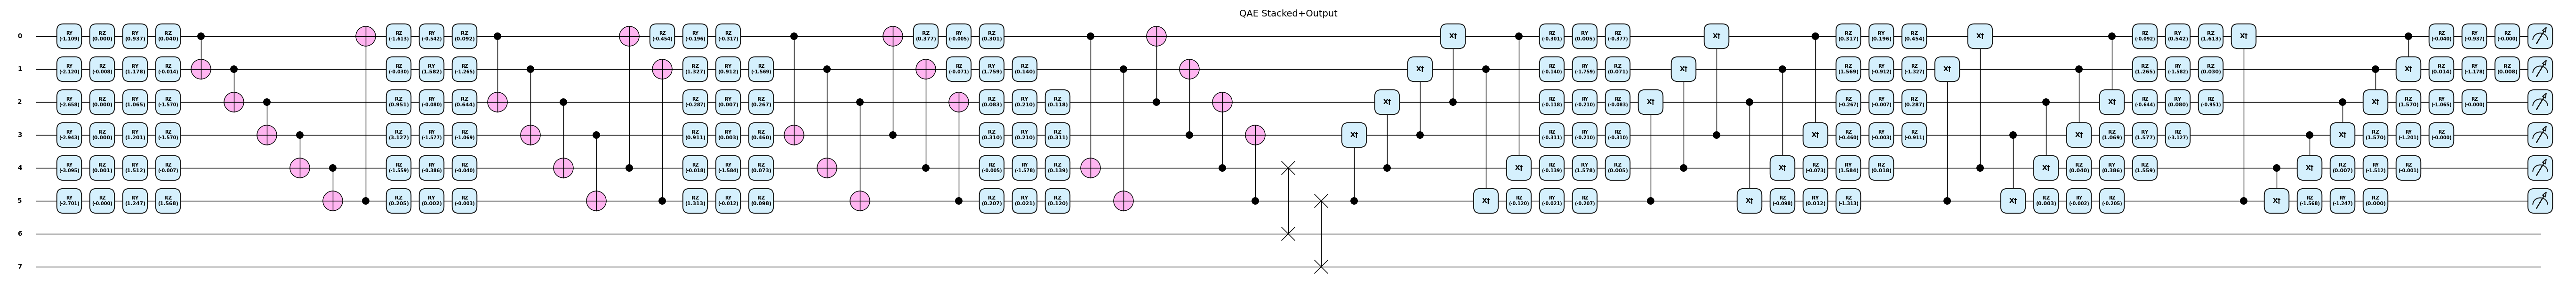

In [32]:
### For reproducibility, needed for random initialisation
np.random.seed(seed)

### Inspect model parameters
stacked_dec_shape = entangler_shape(n_layers, n_latent+n_trash, rot) # Fixed weights
stacked_enc_shape = entangler_shape(n_layers, n_latent+n_trash, rot)
stacked_n_weights = np.prod(stacked_enc_shape)
print(f'Stacked QAE shape: {stacked_enc_shape}, weights: {int(stacked_n_weights)}\n')

### Preparing weight initialisation (also using fixed optimum decoder weights)
#   Two options considered for the encoder:
#   random - stacked_init_weights = np.random.rand(*stacked_enc_shape, requires_grad=True)*2*np.pi
#   mirror - stacked_init_weights = inv_decoder_opt_weights.copy()
stacked_init_weights = inv_decoder_opt_weights.copy()
print(f'Fixed inv decoder init weights shape: {inv_decoder_opt_weights.shape}')
print(f'Trainable encoder init weights shape: {stacked_init_weights.shape}')

### Pure data for training
print(f'Pure data y shape: {y_train_tens.shape}\n')

### Wires requirements
stacked_n_wires = n_latent+2*n_trash
stacked_wires = list(range(stacked_n_wires))
print(f'Wires ({stacked_n_wires}): {stacked_wires}\n')

### Define a sidekick QAE
stacked_dev = qml.device(sim, wires=stacked_wires, seed=seed, shots=shots)
qae_stacked = qae_stacked_model(stacked_wires, inv_decoder_opt_weights,
    n_latent, n_trash, n_layers, rot)
qae_stacked_qc = qml.QNode(qae_stacked, stacked_dev, interface=interface, diff_method=diff_method)
draw_circuit(qae_stacked_qc, scale=0.7, decimals=3, title='QAE Stacked+Output', level='device') \
    (stacked_init_weights, y_train_tens[0]) # expansion_strategy='device'/'gradient'

### Training run

In [33]:
### For reproducibility
np.random.seed(seed)

### Preparation for training
opt = qml.AdamOptimizer(stepsize=lr_stacked_initial, beta1=0.99)
cost_fun = cost_fun_gen_on_tensors(qae_stacked_qc, mse_cost_on_tensors)

### Training run
hist_cost, hist_params, init_weights, stats = train_stacked_with_noise(
    qae_stacked_qc, y, cost_fun, opt, n_stacked_epochs, stacked_init_weights, 
    wind_size=wind_size, wind_step=wind_step, noise=noise, weight_scaler=stacked_weight_scaler,
    prompt_fract=0.1, seed=seed, scale_low=y_low, scale_high=y_high)

Iter: 000 (0001 sec) cost=0.227157 (opt LR=0.0500)
Iter: 020 (0021 sec) cost=0.101690 (opt LR=0.0350)
Iter: 040 (0042 sec) cost=0.115282 (opt LR=0.0245)
Iter: 060 (0062 sec) cost=0.087598 (opt LR=0.0171)
Iter: 080 (0083 sec) cost=0.097378 (opt LR=0.0120)
Iter: 100 (0103 sec) cost=0.097746 (opt LR=0.0084)
Iter: 120 (0124 sec) cost=0.096338 (opt LR=0.0059)
Iter: 140 (0145 sec) cost=0.085662 (opt LR=0.0041)
Iter: 160 (0166 sec) cost=0.098597 (opt LR=0.0029)
Iter: 180 (0186 sec) cost=0.075427 (opt LR=0.0020)

Training completed: epochs=200, min cost=0.074023 @ 194, time=206 secs



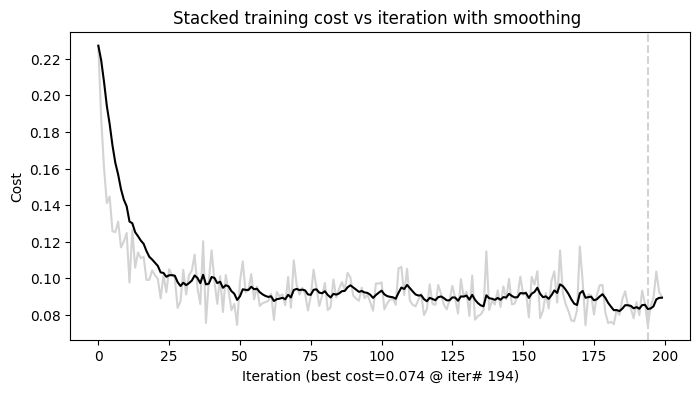

In [34]:
### Plot training cost
#   Note that best model may not have been saved
#   because models are being saved at predefined intervals (log_interv)
meas_plot(hist_cost, meas='cost', task='min', title_pref='Stacked training',
    rcParams=(8, 4), log_interv=1, backplot=True, back_color='lightgray', smooth_weight=0.8)

In [35]:
stacked_train_opt = int(stats[0])
stacked_cost_opt = np.round(hist_cost[stacked_train_opt], 5)
stacked_costs = np.array(hist_cost)
stacked_weights = np.array(hist_params)
stacked_init_weights = np.array(init_weights)
stacked_opt_weights = np.array(hist_params[stacked_train_opt])
print(f'Finished training inverted decoder. Retained:\n')
print(f'\tCosts {stacked_costs.shape}: {stacked_cost_opt} @ {stacked_train_opt}')
print(f'\tWeights {stacked_weights.shape}')
print(f'\tInitial weights {stacked_init_weights.shape}')
print(f'\tOptimum weights {stacked_opt_weights.shape}')

Finished training inverted decoder. Retained:

	Costs (200,): 0.07402 @ 194
	Weights (200, 4, 6, 3)
	Initial weights (4, 6, 3)
	Optimum weights (4, 6, 3)


# <font color="blue">Model testing and scoring</font>
We have to remember that the original data was recoded from the range [0, 1] to the range [-pi, 0]. However, the full QAE results will be returned as expectation values in the range [-1, 1], so they have to be rescaled back to the range [0,1] for scoring, comparison and plotting.

### Model preparation


Training data (74, 6)
Full QAE fixed shape: (4, 6, 3)+(4, 6, 3), weights: 144
Encoder Fixed Weights (4, 6, 3)

Decoder Fixed Weights (4, 6, 3)


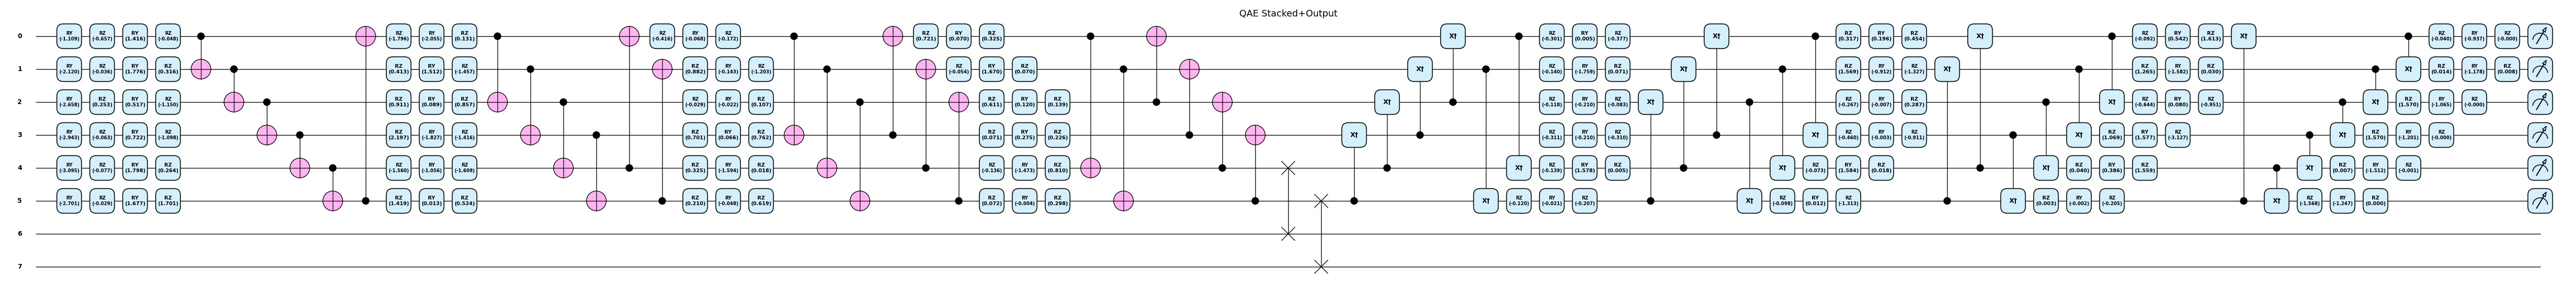

In [36]:
### Data preparation
qae_n_wires = n_latent + 2*n_trash
qae_wires = list(range(qae_n_wires))

qae_enc_shape = entangler_shape(n_layers, n_latent+n_trash, rot)
qae_dec_shape = entangler_shape(n_layers, n_latent+n_trash, rot) # Mirror structure
qae_n_weights = np.prod(qae_enc_shape)+np.prod(qae_dec_shape)

print(f'\nTraining data {y_train_tens.shape}')
print(f'Full QAE fixed shape: {qae_enc_shape}+{qae_dec_shape}, weights: {int(qae_n_weights)}')
print(f'Encoder Fixed Weights {stacked_opt_weights.shape}\n')
print(f'Decoder Fixed Weights {inv_decoder_opt_weights.shape}')

### Create a full QAE

# Define a static QAE encoder
qae_full = qae_full_model(qae_wires, stacked_opt_weights, inv_decoder_opt_weights,
    n_latent, n_trash, n_layers, rot)

# Create and draw a full-QAE
qae_dev = qml.device(sim, wires=qae_wires, seed=seed, shots=shots)
qae_full_qc = qml.QNode(qae_full, qae_dev, interface=interface, diff_method=diff_method)

draw_circuit(qae_full_qc, scale=0.7, decimals=3, title='QAE Stacked+Output', level='device') \
    (y_train_tens[0]) # expansion_strategy='device'/'gradient'

### Flattening of time series data for scoring and plotting

In [37]:
### Reconstruct pure and noisy training TSs
pred_from_pure_train_tens = np.stack([qae_full_qc(x) for x in X_train_tens], requires_grad=False)
pred_from_pure_test_tens = np.stack([qae_full_qc(x) for x in X_test_tens], requires_grad=False)
pred_from_noisy_train_tens = np.stack([qae_full_qc(x) for x in X_train_noisy_tens], requires_grad=False)
pred_from_noisy_test_tens = np.stack([qae_full_qc(x) for x in X_test_noisy_tens], requires_grad=False)

### Flatten recovered TSs and recode their values to range [0..1]

# These were TS encoded in the range [-pi..0]
X_train_flat_ts = ts_wind_flatten_avg(X_train_tens, wind_step)/np.pi+1
X_test_flat_ts = ts_wind_flatten_avg(X_test_tens, wind_step)/np.pi+1
X_train_noisy_flat_ts = ts_wind_flatten_avg(X_train_noisy_tens, wind_step)/np.pi+1
X_test_noisy_flat_ts = ts_wind_flatten_avg(X_test_noisy_tens, wind_step)/np.pi+1

# These TS were measured as expvals in the range [-1..1]
pred_from_pure_train_flat = (ts_wind_flatten_avg(pred_from_pure_train_tens, wind_step)+1)/2
pred_from_pure_test_flat = (ts_wind_flatten_avg(pred_from_pure_test_tens, wind_step)+1)/2
pred_from_noisy_train_flat = (ts_wind_flatten_avg(pred_from_noisy_train_tens, wind_step)+1)/2
pred_from_noisy_test_flat = (ts_wind_flatten_avg(pred_from_noisy_test_tens, wind_step)+1)/2

### Scoring of the model <font color="red">selected on training</font>

In [38]:
### Calculate metrics to show in charts
#   Note that all pure X = pure y, noise was injected into X only
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mse_train_pure_vs_noisy = mean_squared_error(X_train_flat_ts, X_train_noisy_flat_ts)
mse_test_pure_vs_noisy = mean_squared_error(X_test_flat_ts, X_test_noisy_flat_ts)
mse_train_pure_vs_rec_from_pure = mean_squared_error(X_train_flat_ts, pred_from_pure_train_flat)
mse_test_pure_vs_rec_from_pure = mean_squared_error(X_test_flat_ts, pred_from_pure_test_flat)
mse_train_pure_vs_rec_from_noisy = mean_squared_error(X_train_flat_ts, pred_from_noisy_train_flat)
mse_test_pure_vs_rec_from_noisy = mean_squared_error(X_test_flat_ts, pred_from_noisy_test_flat)

In [39]:
print(f'MSE train (pure vs noise) ~ (pure vs recovered from pure) =  '+\
      f'{mse_train_pure_vs_noisy:0.4f} ~ {mse_train_pure_vs_rec_from_pure:0.4f}')
print(f'MSE test  (pure vs noise) ~ (pure vs recovered from pure) =  '+\
      f'{mse_test_pure_vs_noisy:0.4f} ~ {mse_test_pure_vs_rec_from_pure:0.4f}\n')

print(f'MSE train (pure vs noise) ~ (pure vs recovered from noisy) = '+\
      f'{mse_train_pure_vs_noisy:0.4f} ~ {mse_train_pure_vs_rec_from_noisy:0.4f}')
print(f'MSE test  (pure vs noise) ~ (pure vs recovered from noisy) = '+\
      f'{mse_test_pure_vs_noisy:0.4f} ~ {mse_test_pure_vs_rec_from_noisy:0.4f}')

MSE train (pure vs noise) ~ (pure vs recovered from pure) =  0.0413 ~ 0.0090
MSE test  (pure vs noise) ~ (pure vs recovered from pure) =  0.0323 ~ 0.0112

MSE train (pure vs noise) ~ (pure vs recovered from noisy) = 0.0413 ~ 0.0235
MSE test  (pure vs noise) ~ (pure vs recovered from noisy) = 0.0323 ~ 0.0229


### Plotting of data "recovery" from <font color="red">clean data</font>

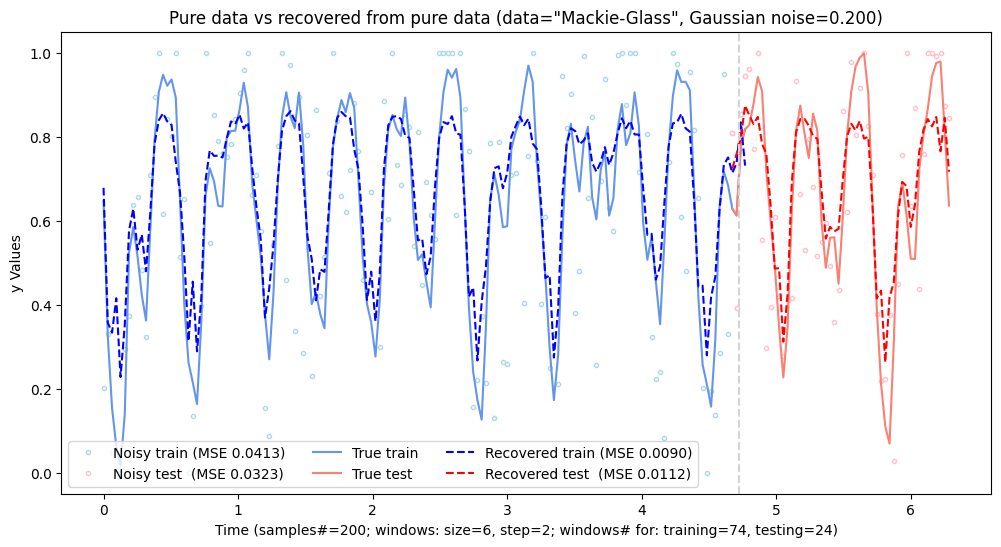

In [40]:
### Plot the original and recovered from pure data with added performance metrics
# exper_from_pure_train_flat = 4*(0.5-pred_from_pure_train_flat)+1
# exper_from_pure_test_flat = 4*(0.5-pred_from_pure_test_flat)+1

# Plot partitions
print()
# Plot partitions
print()
plt.figure(figsize=(12, 6))
plt.plot(X_train_flat_coords, X_train_noisy_flat_ts, color="lightblue", linestyle='', mfc='white', marker='.', 
         label=f"Noisy train (MSE {mse_train_pure_vs_noisy:0.4f})")
plt.plot(X_test_flat_coords, X_test_noisy_flat_ts, color="pink", linestyle='', mfc='white', marker='.', 
         label=f"Noisy test  (MSE {mse_test_pure_vs_noisy:0.4f})")
plt.plot(X_train_flat_coords, X_train_flat_ts, label="True train", color="cornflowerblue")
plt.plot(X_test_flat_coords, X_test_flat_ts, label="True test", color="salmon")
plt.plot(X_train_flat_coords, pred_from_pure_train_flat, color="blue", linestyle='dashed', 
         label=f"Recovered train (MSE {mse_train_pure_vs_rec_from_pure:0.4f})")
plt.plot(X_test_flat_coords, pred_from_pure_test_flat, color="red", linestyle='dashed', 
         label=f"Recovered test  (MSE {mse_test_pure_vs_rec_from_pure:0.4f})")
plt.axvline(x=(X_train_flat_coords[-1]+X_test_flat_coords[0])/2, color="lightgray", linestyle='dashed')
plt.xlabel(f'Time (samples#={n_samples}; windows: size={wind_size}, step={wind_step}; windows# for: training={n_train}, testing={n_test})')
plt.ylabel('y Values')
plt.title(f'Pure data vs recovered from pure data (data="Mackie-Glass", Gaussian noise={noise:0.3f})')
plt.legend(loc='lower left', ncol=3)
plt.show()
print()

### Plotting of data recovery from <font color="red">noisy data</font>

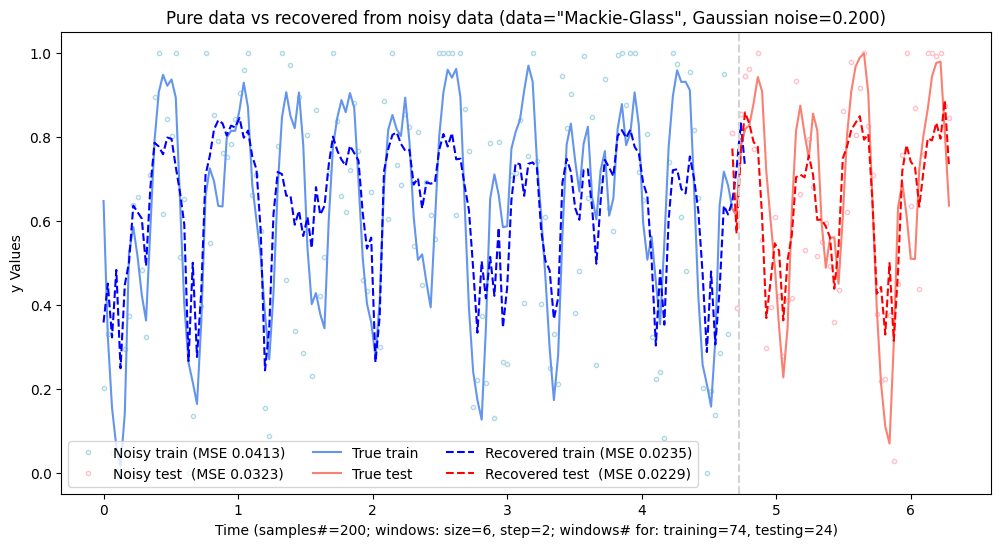

In [41]:
### Plot the original and recovered from noisy data with added performance metrics

# Plot partitions
print()
plt.figure(figsize=(12, 6))
plt.plot(X_train_flat_coords, X_train_noisy_flat_ts, color="lightblue", linestyle='', mfc='white', marker='.', 
         label=f"Noisy train (MSE {mse_train_pure_vs_noisy:0.4f})")
plt.plot(X_test_flat_coords, X_test_noisy_flat_ts, color="pink", linestyle='', mfc='white', marker='.', 
         label=f"Noisy test  (MSE {mse_test_pure_vs_noisy:0.4f})")
plt.plot(X_train_flat_coords, X_train_flat_ts, label="True train", color="cornflowerblue")
plt.plot(X_test_flat_coords, X_test_flat_ts, label="True test", color="salmon")
plt.plot(X_train_flat_coords, pred_from_noisy_train_flat, color="blue", linestyle='dashed', 
         label=f"Recovered train (MSE {mse_train_pure_vs_rec_from_noisy:0.4f})")
plt.plot(X_test_flat_coords, pred_from_noisy_test_flat, color="red", linestyle='dashed', 
         label=f"Recovered test  (MSE {mse_test_pure_vs_rec_from_noisy:0.4f})")
plt.axvline(x=(X_train_flat_coords[-1]+X_test_flat_coords[0])/2, color="lightgray", linestyle='dashed')
plt.xlabel(f'Time (samples#={n_samples}; windows: size={wind_size}, step={wind_step}; windows# for: training={n_train}, testing={n_test})')
plt.ylabel('y Values')
plt.title(f'Pure data vs recovered from noisy data (data="Mackie-Glass", Gaussian noise={noise:0.3f})')
plt.legend(loc='lower left', ncol=3)
plt.show()
print()

# Software in use (Linux)

In [42]:
import os
os.system('pip list | grep -e pennylane -e torch');

pennylane                 0.42.3
pennylane_lightning       0.42.0
torch                     2.8.0
torchaudio                2.8.0
torcheval                 0.0.7
torchmetrics              1.8.2
torchsummary              1.5.1
torchvision               0.23.0
